In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

SEED=63
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
def add_noise(img, noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=np.sqrt(var)
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img+=noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img*=noise
    return img

In [3]:
#Here we load the dataset from keras
(X,y),(X_test,y_test)=mnist.load_data()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=SEED)

print('Train set size :',len(X_train))
print('Val set size   :',len(X_val))
print('Test set size  :',len(X_test))

Train set size : 45000
Val set size   : 15000
Test set size  : 10000


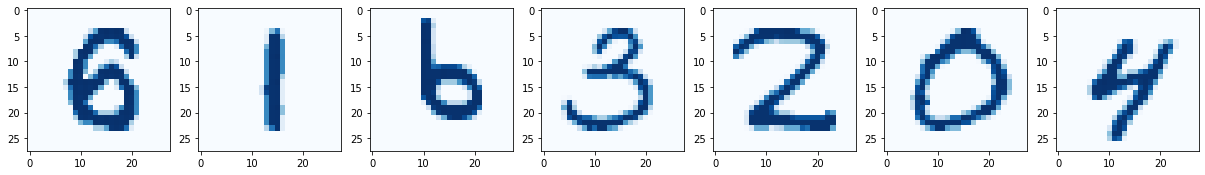

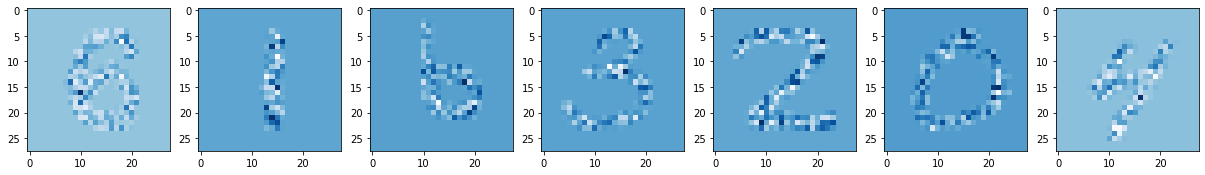

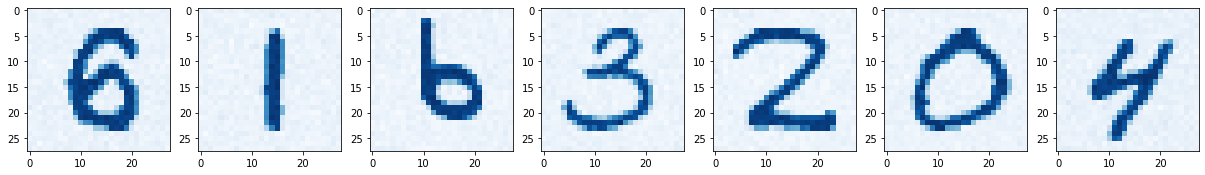

In [4]:
fig0,ax0=plt.subplots(figsize=(21,4), nrows=1, ncols=7)
for i in range(7):
    ax0[i].imshow(X_train[i], cmap='Blues');

fig1,ax1=plt.subplots(figsize=(21,4), nrows=1, ncols=7)
for i in range(7):
    img=add_noise(X_train[i],"speckle")
    ax1[i].imshow(img, cmap='Blues');

fig2,ax2=plt.subplots(figsize=(21,4), nrows=1, ncols=7)
for i in range(7):
    img=add_noise(X_train[i],"gaussian")
    ax2[i].imshow(img, cmap='Blues');

In [5]:
def get_noisy_data(data):
    i=0
    noisy_data=[]
    for x in data:
        if i<=len(data)//2:
            noisy_x=add_noise(x,'gaussian')
            noisy_data.append(noisy_x)
        else:
            noisy_x=add_noise(x,'speckle')
            noisy_data.append(noisy_x)
        i+=1
    return np.array(noisy_data)

noisyX_train=get_noisy_data(X_train)
noisyX_val=get_noisy_data(X_val)
noisyX_test=get_noisy_data(X_test)

In [6]:
BATCH_SIZE=16
EPOCHS=50
LR=0.001

In [7]:
class ImageSet(Dataset):
    def __init__(self, X, noisy_X, y, transformations):
        self.X=X
        self.nX=noisy_X
        self.y=y
        self.trans=transformations

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        xNoise=self.nX[i]
        xClean=self.X[i]
        y=self.y[i]
        
        if self.trans != None:
            xNoise=self.trans(xNoise)
            xClean=self.trans(xClean)

        return (xNoise,xClean,y)

In [8]:
transformations=transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

In [9]:
train_data=ImageSet(X_train, noisyX_train, y_train, transformations)
val_data=ImageSet(X_val, noisyX_val, y_val, transformations)
test_data=ImageSet(X_test, noisyX_test, y_test, transformations)

In [10]:
train_loader=DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader=DataLoader(val_data, BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_data, BATCH_SIZE, shuffle=True)

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()

        self.enco1=nn.Linear(28*28,256)
        self.enco2=nn.Linear(256,128)
        self.enco3=nn.Linear(128,64)

        self.deco1=nn.Linear(64,64)
        self.deco2=nn.Linear(64,128)
        self.deco3=nn.Linear(128,256)

        self.out=nn.Linear(256,28*28)

        self.bn1=nn.BatchNorm1d(256)
        self.bn2=nn.BatchNorm1d(128)
        self.bn3=nn.BatchNorm1d(64)

    def forward(self, x):
        x=self.bn1(F.relu(self.enco1(x)))
        x=self.bn2(F.relu(self.enco2(x)))
        x=self.bn3(F.relu(self.enco3(x)))

        x=self.bn3(F.relu(self.deco1(x)))
        x=self.bn2(F.relu(self.deco2(x)))
        x=self.bn1(F.relu(self.deco3(x)))

        x=torch.sigmoid(self.out(x))

        return x

In [12]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else :
    device=torch.device('cpu')

print(device)

cpu


In [13]:
model=AutoEncoder()
model=model.to(device)
print(model)

AutoEncoder(
  (enco1): Linear(in_features=784, out_features=256, bias=True)
  (enco2): Linear(in_features=256, out_features=128, bias=True)
  (enco3): Linear(in_features=128, out_features=64, bias=True)
  (deco1): Linear(in_features=64, out_features=64, bias=True)
  (deco2): Linear(in_features=64, out_features=128, bias=True)
  (deco3): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=784, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
criteria=nn.MSELoss()

optimizer=optim.Adam(model.parameters(), LR)

In [15]:
train_loss, val_loss = [], []
elapsed_time=0.0

for epoch in range(EPOCHS):
    epoch_start=time.time()
    running_loss=0.0
    for noisy, clean, y in train_loader:
        clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
        noisy=noisy.view(noisy.size(0),-1).type(torch.FloatTensor)

        optimizer.zero_grad()
        z=model(noisy.to(device))
        loss=criteria(z,clean.to(device))
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    epoch_loss=running_loss/len(train_loader)

    model.eval()
    running_loss_test = 0.0
    for noisy, clean, y in val_loader:
        clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
        noisy=noisy.view(noisy.size(0),-1).type(torch.FloatTensor)

        z=model(noisy.to(device))
        loss=criteria(z,clean.to(device))
        running_loss_test+=loss.item()
    epoch_loss_val=running_loss_test/len(val_loader)

    train_loss.append(epoch_loss)
    val_loss.append(epoch_loss_val)
    epoch_end=time.time()

    epoch_elapsed_time=(epoch_end-epoch_start)
    elapsed_time+=epoch_elapsed_time
    print('Epoch {:g}/{:g} : Train Loss : {:0.4f} === Val Loss : {:0.4f} (Elapsed Time: {:0.2f}sec)'.format(epoch+1, EPOCHS, epoch_loss, epoch_loss_val, epoch_elapsed_time))

print('\nTotal Elapsed Time : {:g}min {:.0f}sec'.format(elapsed_time//60, elapsed_time%60))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


Epoch 1/50 : Train Loss : 0.0551 === Val Loss : 0.0675 (Elapsed Time: 58.99sec)
Epoch 2/50 : Train Loss : 0.0398 === Val Loss : 0.0349 (Elapsed Time: 46.57sec)
Epoch 3/50 : Train Loss : 0.0307 === Val Loss : 0.0290 (Elapsed Time: 45.56sec)
Epoch 4/50 : Train Loss : 0.0261 === Val Loss : 0.0262 (Elapsed Time: 45.56sec)
Epoch 5/50 : Train Loss : 0.0231 === Val Loss : 0.0240 (Elapsed Time: 45.64sec)
Epoch 6/50 : Train Loss : 0.0211 === Val Loss : 0.0226 (Elapsed Time: 45.48sec)
Epoch 7/50 : Train Loss : 0.0196 === Val Loss : 0.0220 (Elapsed Time: 47.01sec)
Epoch 8/50 : Train Loss : 0.0186 === Val Loss : 0.0209 (Elapsed Time: 46.41sec)
Epoch 9/50 : Train Loss : 0.0177 === Val Loss : 0.0202 (Elapsed Time: 45.67sec)
Epoch 10/50 : Train Loss : 0.0170 === Val Loss : 0.0197 (Elapsed Time: 45.54sec)
Epoch 11/50 : Train Loss : 0.0164 === Val Loss : 0.0195 (Elapsed Time: 45.55sec)
Epoch 12/50 : Train Loss : 0.0158 === Val Loss : 0.0191 (Elapsed Time: 45.70sec)
Epoch 13/50 : Train Loss : 0.0154 ===

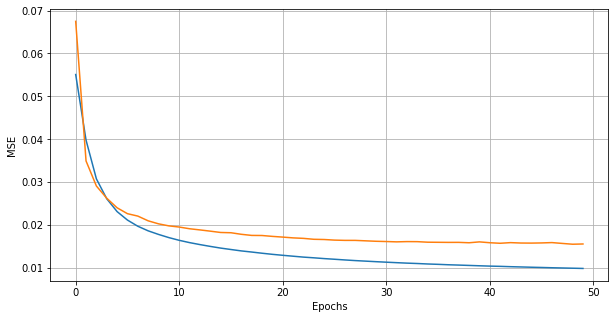

In [27]:
plt.figure(figsize=(10,5))
plt.plot(range(EPOCHS), train_loss)
plt.plot(range(EPOCHS), val_loss)
plt.grid(True);
plt.xlabel('Epochs');
plt.ylabel('MSE');

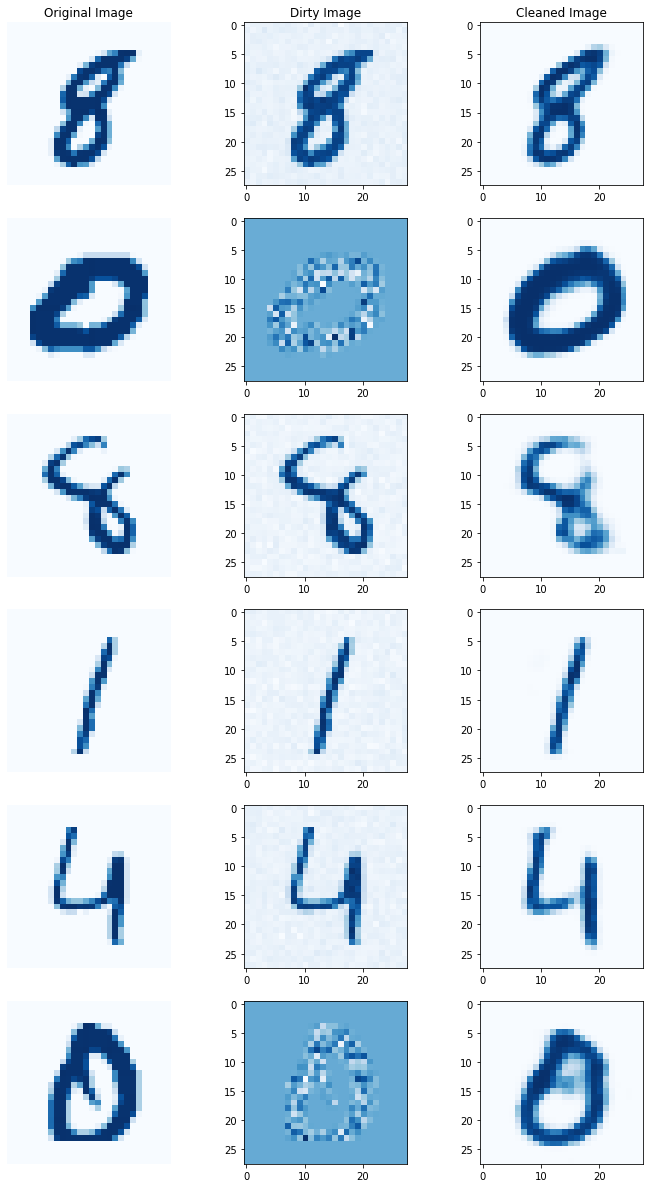

In [24]:
f,axes= plt.subplots(6,3,figsize=(12,21))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=test_data[test_imgs[idx]][0]
  clean=test_data[test_imgs[idx]][1]
  label=test_data[test_imgs[idx]][2]

  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="Blues")
  axes[idx,0].axis(False);
  axes[idx,1].imshow(dirty,cmap="Blues")
  axes[idx,0].axis(False);
  axes[idx,2].imshow(output,cmap="Blues")
  axes[idx,0].axis(False);